In [37]:
import bitdotio
import datetime
import dotenv
from getpass import getpass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow

if os.getenv("BITDOTIO_API_KEY"):
    print("bit.io API Key Present in Global Environment")
else:
    os.environ["BITDOTIO_API_KEY"] = getpass("Please enter your API Key")

# Check out https://github.com/bitdotioinc/python-bitdotio for more examples and documentation
client = bitdotio.bitdotio(os.environ.get("BITDOTIO_API_KEY"))

bit.io API Key Present in Global Environment


In [2]:
neiss = pd.read_csv("../neiss_data.csv", low_memory=False)
neiss.set_index("CPSC_Case_Number", inplace=True)
neiss.head()

,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,...,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative,Stratum,PSU,Weight
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,2016-01-01T00:00:00Z,92.0,Male,N.S.,NaN,NaN,LOWER TRUNK,FRACTURE,NaN,NaN,...,NO/?,DAY WEAR,FLOORS OR FLOORING MATERIALS,NaN,NaN,NaN,92YOM TRYINGO TO TAKE OFF PANTS AND LOST BALAN...,M,63,103.2251
160101847,2016-01-01T00:00:00Z,90.0,Male,N.S.,NaN,NaN,LOWER TRUNK,FRACTURE,NaN,NaN,...,NO/?,RECLINER CHAIR,NaN,NaN,NaN,NaN,90YOM FELL GETTING OUT OF A RECLINER CHAIR AND...,M,63,103.2251
160101848,2016-01-01T00:00:00Z,71.0,Female,N.S.,NaN,NaN,LOWER TRUNK,FRACTURE,NaN,NaN,...,NO/?,FLOORS OR FLOORING MATERIALS,NaN,NaN,NaN,NaN,71YOF SLIPPED AND FELL TO HER WET KITCHEN FLOO...,M,63,103.2251
160101852,2016-01-01T00:00:00Z,71.0,Female,N.S.,NaN,NaN,UPPER TRUNK,"STRAIN, SPRAIN",NaN,NaN,...,NO/?,"BAGS, NOT ELSEWHERE CLASSIFIED",NaN,NaN,NaN,NaN,71YOF CARRYING A 50 POUND BAG AND STRAINED CHE...,M,63,103.2251
160101857,2016-01-01T00:00:00Z,57.0,Male,N.S.,NaN,NaN,FOOT,LACERATION,NaN,NaN,...,NO/?,"KNIVES, NOT ELSEWHERE CLASSIFIED",NaN,NaN,NaN,NaN,57YOM DROPPED A KNIFE ONTO LEFT FOOT LACERATIO...,M,63,103.2251


# Data Preparation
We are interested in outlier detection -- specifically regarding *which products are responsible for injuries*. So this means two things: over the course of five years, are there particular days that really stand out? And are there any days in the year that stand out?

## Made Dummy Variables of Product Categories

In [3]:
prod1_dummies = pd.get_dummies(neiss.Product_1, prefix="prod")
prod2_dummies = pd.get_dummies(neiss.Product_2, prefix="prod")
prod3_dummies = pd.get_dummies(neiss.Product_3, prefix="prod")

In [4]:
prod1_dummies.shape, prod2_dummies.shape,  prod3_dummies.shape

((1791854, 801), (1791854, 751), (1791854, 512))

In [5]:
_ = prod1_dummies.add(prod2_dummies, axis=1, fill_value=0)
df = _.add(prod3_dummies, axis=1, fill_value=0)
df.set_index(neiss.index, inplace=True)
df.head()

,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,prod_AIR PURIFIERS,prod_ALCOHOL (BEVERAGE),...,"prod_WOOD BURNING FIREPLACES, FACTORY BUILT",prod_WOOD PANELING AND PARTICLEBOARD,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,0,0,0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0.0,0,0,0,0,0
160101847,0,0,0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0.0,0,0,0,0,0
160101848,0,0,0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0.0,0,0,0,0,0
160101852,0,0,0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0.0,0,0,0,0,0
160101857,0,0,0,0.0,0,0,0,0,0,0,...,0.0,0,0.0,0,0.0,0,0,0,0,0


In [6]:
sub = neiss.iloc[:, [0, -1]]
analysis = pd.concat([sub, df], axis=1)
del([neiss, sub])

## Multiply Dummy Vars by Weights

In [8]:
#analysis.iloc[:,2:] * analysis.iloc[1]
#analysis_wt = analysis
weighted_incidents = analysis.iloc[:,2:].values * np.expand_dims(analysis.iloc[:,1].values,1)

In [9]:
#analysis_wt.iloc[:, 2:] = weighted_incidents
df_wt = pd.DataFrame(weighted_incidents, index = analysis.index, columns=analysis.iloc[:,2:].columns)

df_out = pd.concat([analysis.iloc[:,0:2], df_wt], axis=1)
df_out.head()

,Treatment_Date,Weight,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,...,"prod_WOOD BURNING FIREPLACES, FACTORY BUILT",prod_WOOD PANELING AND PARTICLEBOARD,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160101847,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160101848,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160101852,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160101857,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_out.iloc[150000][df_out.iloc[150000] != 0]

Treatment_Date                                        2016-06-07T00:00:00Z
Weight                                                             14.6504
prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.                 14.6504
Name: 160629758, dtype: object

In [28]:
df_out['date'] = pd.to_datetime(df_out['Treatment_Date'],format='%Y-%m-%d')
df_out['year'] = pd.DatetimeIndex(df_out['date']).year
df_out['month'] = pd.DatetimeIndex(df_out['date']).month
df_out['doy'] = pd.DatetimeIndex(df_out['date']).dayofyear

In [38]:
df_out.to_parquet("../outlier_df.parquet")

# Start Here for Analysis Component

In [78]:
import datetime
import dotenv
from getpass import getpass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

In [62]:
df = pd.read_parquet("../outlier_df.parquet")
df.head()

,Treatment_Date,Weight,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,...,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES,date,year,month,doy
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00,2016,1,1
160101847,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00,2016,1,1
160101848,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00,2016,1,1
160101852,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00,2016,1,1
160101857,2016-01-01T00:00:00Z,103.2251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00,2016,1,1


## Analysis 1: Grouped by Date

In [54]:
bydate = df.drop(["Weight", "Treatment_Date", "year", "month", "doy"], axis=1)
bydate.head()

,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,prod_AIR PURIFIERS,prod_ALCOHOL (BEVERAGE),...,prod_WOOD PANELING AND PARTICLEBOARD,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES,date
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00
160101847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00
160101848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00
160101852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00
160101857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00


In [58]:
bydate_grouped = bydate.groupby('date').agg('sum')
bydate_grouped.head()

,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,prod_AIR PURIFIERS,prod_ALCOHOL (BEVERAGE),...,"prod_WOOD BURNING FIREPLACES, FACTORY BUILT",prod_WOOD PANELING AND PARTICLEBOARD,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,175.4412,52.7577,0.0
2016-01-02 00:00:00+00:00,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,68.0470,0.0,0.0,0.0000,190.9457,100.2778,0.0
2016-01-03 00:00:00+00:00,4.5056,0.0,0.0,0.0000,0.0000,0.0,0.0,4.5056,0.0,0.0,...,0.0,0.0,0.0,16.1154,0.0,0.0,0.0000,87.7206,262.4399,0.0
2016-01-04 00:00:00+00:00,0.0000,0.0,0.0,0.0000,72.8490,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,153.4783,0.0
2016-01-05 00:00:00+00:00,0.0000,0.0,0.0,103.2251,16.1154,0.0,0.0,68.0470,0.0,0.0,...,0.0,0.0,0.0,87.7206,0.0,0.0,4.5056,0.0000,20.6210,0.0


In [59]:
bydate_grouped

,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,prod_AIR PURIFIERS,prod_ALCOHOL (BEVERAGE),...,"prod_WOOD BURNING FIREPLACES, FACTORY BUILT",prod_WOOD PANELING AND PARTICLEBOARD,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,175.4412,52.7577,0.0
2016-01-02 00:00:00+00:00,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,68.0470,0.0,0.0,0.0000,190.9457,100.2778,0.0
2016-01-03 00:00:00+00:00,4.5056,0.0,0.000,0.0000,0.0000,0.0000,0.0,4.5056,0.0,0.0,...,0.0,0.0,0.0,16.1154,0.0,0.0,0.0000,87.7206,262.4399,0.0
2016-01-04 00:00:00+00:00,0.0000,0.0,0.000,0.0000,72.8490,0.0000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,153.4783,0.0
2016-01-05 00:00:00+00:00,0.0000,0.0,0.000,103.2251,16.1154,0.0000,0.0,68.0470,0.0,0.0,...,0.0,0.0,0.0,87.7206,0.0,0.0,4.5056,0.0000,20.6210,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 00:00:00+00:00,0.0000,0.0,4.851,0.0000,0.0000,16.8413,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,4.8510,0.0,0.0,0.0000,0.0000,83.2641,0.0
2020-12-28 00:00:00+00:00,0.0000,0.0,0.000,0.0000,78.1602,0.0000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0000,9.7020,0.0
2020-12-29 00:00:00+00:00,4.8510,0.0,0.000,78.1602,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,16.8413,0.0,0.0,0.0000,0.0000,4.8510,0.0


In [67]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01) # Looking for 1%
X = bydate_grouped.values
X

array([[  0.    ,   0.    ,   0.    , ..., 175.4412,  52.7577,   0.    ],
       [  0.    ,   0.    ,   0.    , ..., 190.9457, 100.2778,   0.    ],
       [  4.5056,   0.    ,   0.    , ...,  87.7206, 262.4399,   0.    ],
       ...,
       [  4.851 ,   0.    ,   0.    , ...,   0.    ,   4.851 ,   0.    ],
       [  4.851 ,   0.    ,   0.    , ...,  78.4131,   0.    ,   0.    ],
       [ 78.4131,   0.    ,   0.    , ...,   0.    ,  88.1151,   0.    ]])

In [68]:
y_pred = clf.fit_predict(X)


In [69]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [77]:
bydate_grouped.index[y_pred==-1]

DatetimeIndex(['2016-01-24 00:00:00+00:00', '2016-01-25 00:00:00+00:00',
               '2016-01-26 00:00:00+00:00', '2016-02-21 00:00:00+00:00',
               '2016-07-04 00:00:00+00:00', '2016-11-24 00:00:00+00:00',
               '2016-12-25 00:00:00+00:00', '2017-02-08 00:00:00+00:00',
               '2017-07-04 00:00:00+00:00', '2017-07-05 00:00:00+00:00',
               '2017-09-12 00:00:00+00:00', '2017-12-25 00:00:00+00:00',
               '2018-07-04 00:00:00+00:00', '2018-12-25 00:00:00+00:00',
               '2019-07-04 00:00:00+00:00', '2019-12-25 00:00:00+00:00',
               '2020-07-04 00:00:00+00:00', '2020-07-05 00:00:00+00:00',
               '2020-11-26 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)

In [97]:
pca = PCA(n_components=2)

In [98]:
pca_vals = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.17985014, 0.13985041])

In [92]:
bydate_grouped.index[y_pred==-1], pca_vals[y_pred!=-1].mean()

(DatetimeIndex(['2016-01-24 00:00:00+00:00', '2016-01-25 00:00:00+00:00',
                '2016-01-26 00:00:00+00:00', '2016-02-21 00:00:00+00:00',
                '2016-07-04 00:00:00+00:00', '2016-11-24 00:00:00+00:00',
                '2016-12-25 00:00:00+00:00', '2017-02-08 00:00:00+00:00',
                '2017-07-04 00:00:00+00:00', '2017-07-05 00:00:00+00:00',
                '2017-09-12 00:00:00+00:00', '2017-12-25 00:00:00+00:00',
                '2018-07-04 00:00:00+00:00', '2018-12-25 00:00:00+00:00',
                '2019-07-04 00:00:00+00:00', '2019-12-25 00:00:00+00:00',
                '2020-07-04 00:00:00+00:00', '2020-07-05 00:00:00+00:00',
                '2020-11-26 00:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='date', freq=None),
 3.3710824709957055)

In [100]:
pca_vals

array([[  119.72719083,  1380.67270079],
       [ -367.79916687,   756.9779585 ],
       [ -646.34267071,    96.69067484],
       ...,
       [ -901.09938634,   733.86669568],
       [-1447.18754914,    -9.58630332],
       [ -653.91529   ,  1305.14148993]])

In [108]:
# unzip
pc1, pc2 = zip(*pca_vals)

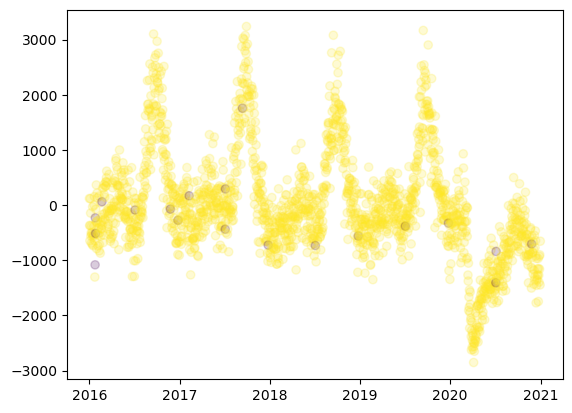

In [116]:
plt.scatter(bydate_grouped.index,pc1, c=y_pred, alpha = 0.2)
plt.show()

OK, there's something cool to explore in 2020. Return to that. Let's now look at month+day without year.

In [127]:
df['day'] = pd.DatetimeIndex(df['date']).day
byday = df.drop(["Weight", "Treatment_Date", "year", "doy", "date"], axis=1)
byday.head()

,prod_< 5 POISONINGS - NO OTHER CODE,prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS),prod_ABRASIVE CLEANERS,prod_ACIDS,prod_ADHESIVES,prod_AEROSOL CONTAINERS,prod_AIR COMPRESSORS (SEPARATE),prod_AIR CONDITIONERS,prod_AIR PURIFIERS,prod_ALCOHOL (BEVERAGE),...,prod_WOODBURNING KITS,prod_WOODEN CONTAINERS,prod_WOODEN MATCHES,prod_WORKSHOP COMPOUNDS OR CHEMICALS,prod_WORKSHOP FURNISHINGS,"prod_WORKSHOP GRINDERS, BUFFERS OR POLISHERS, N.S.","prod_WRESTLING (ACTIVITY, APPAREL OR EQUIPMENT)",prod_WRINGER WASHING MACHINES,month,day
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
160101845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
160101847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
160101848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
160101852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
160101857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [129]:
byday_grouped = byday.groupby(['month','day']).agg('sum')
byday_grouped.head()

prod_< 5 POISONINGS - NO OTHER CODE  \
month day                                        
1     1                                 0.0000   
      2                                 0.0000   
      3                                 4.5056   
      4                                 0.0000   
      5                                 0.0000   

           prod_ABOVE-GROUND SWIMMING POOLS (EXCL PORTABLE POOLS)  \
month day                                                           
1     1                                               0.0000        
      2                                               0.0000        
      3                                               0.0000        
      4                                              16.1828        
      5                                               0.0000        

           prod_ABRASIVE CLEANERS  prod_ACIDS  prod_ADHESIVES  \
month day                                                       
1     1                       0.0      0.0000         83.8040   
      2                       0.0      0.0000         23.1574   
      3                       0.0      0.0000        196.2512   
      4                       0.0      0.0000         89.3122   
      5                       0.0    119.4079        121.1959   

           prod_AEROSOL CONTAINERS  prod_AIR COMPRESSORS (SEPARATE)  \
month day                                                             
1     1                     4.8510                           0.0000   
      2                     0.0000                          54.9889   
      3                    54.9889                           0.0000   
      4                    70.9703                           0.0000   
      5                     0.0000                          17.5136   

           prod_AIR CONDITIONERS  prod_AIR PURIFIERS  prod_ALCOHOL (BEVERAGE)  \
month day                                                                       
1     1                   0.0000                 0.0                    0.000   
      2                  86.9695                 0.0                    0.000   
      3                  20.6884                 0.0                    0.000   
      4                  67.1031                 0.0                    5.518   
      5                 179.2876                 0.0                    0.000   

           ...  prod_WOOD BURNING FIREPLACES, FACTORY BUILT  \
month day  ...                                                
1     1    ...                                          0.0   
      2    ...                                          0.0   
      3    ...                                          0.0   
      4    ...                                          0.0   
      5    ...                                          0.0   

           prod_WOOD PANELING AND PARTICLEBOARD  prod_WOODBURNING KITS  \
month day                                                                
1     1                                 77.6641                    0.0   
      2                                 16.1828                    0.0   
      3                                  0.0000                    0.0   
      4                                 78.1602                    0.0   
      5                                103.5166                    0.0   

           prod_WOODEN CONTAINERS  prod_WOODEN MATCHES  \
month day                                                
1     1                   59.7459                  0.0   
      2                  208.0572                  0.0   
      3                   32.5786                  0.0   
      4                   78.3782                  0.0   
      5                  103.7198                  0.0   

           prod_WORKSHOP COMPOUNDS OR CHEMICALS  prod_WORKSHOP FURNISHINGS  \
month day                                                                    
1     1                                 78.1602                     0.0000   
      2                                 16.1828     

In [130]:
byday_grouped.shape

(366, 803)

In [517]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=.027) # Looking for about 10 days
X = byday_grouped.values
X

array([[   0.    ,    0.    ,    0.    , ...,  468.2569,  474.972 ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,  553.4835,  729.9852,
           0.    ],
       [   4.5056,    0.    ,    0.    , ...,  238.5506, 1064.0931,
           0.    ],
       ...,
       [  21.8429,    0.    ,    0.    , ...,  158.7908,  910.5883,
           0.    ],
       [   4.851 ,    0.    ,    0.    , ...,   78.4131,  734.7734,
           0.    ],
       [  78.4131,    0.    ,    0.    , ...,  305.3152,  183.9893,
           0.    ]])

In [518]:
y_pred = clf.fit_predict(X)
byday_grouped.index[y_pred==-1]

MultiIndex([( 1,  1),
            ( 2, 29),
            ( 6, 25),
            ( 7,  4),
            ( 7,  5),
            (12, 16),
            (12, 23),
            (12, 24),
            (12, 25),
            (12, 31)],
           names=['month', 'day'])

In [519]:
pca = PCA(n_components=3)
pca_vals = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.33478767, 0.21997508, 0.08206818])

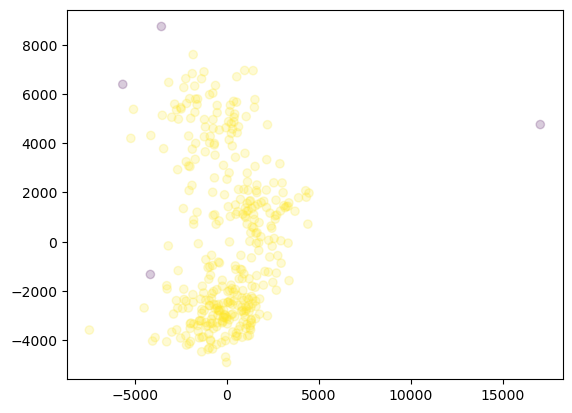

In [513]:
pc1, pc2, pc3 = zip(*pca_vals)
plt.scatter(pc3,pc2, c=y_pred, alpha = 0.2)
plt.show()

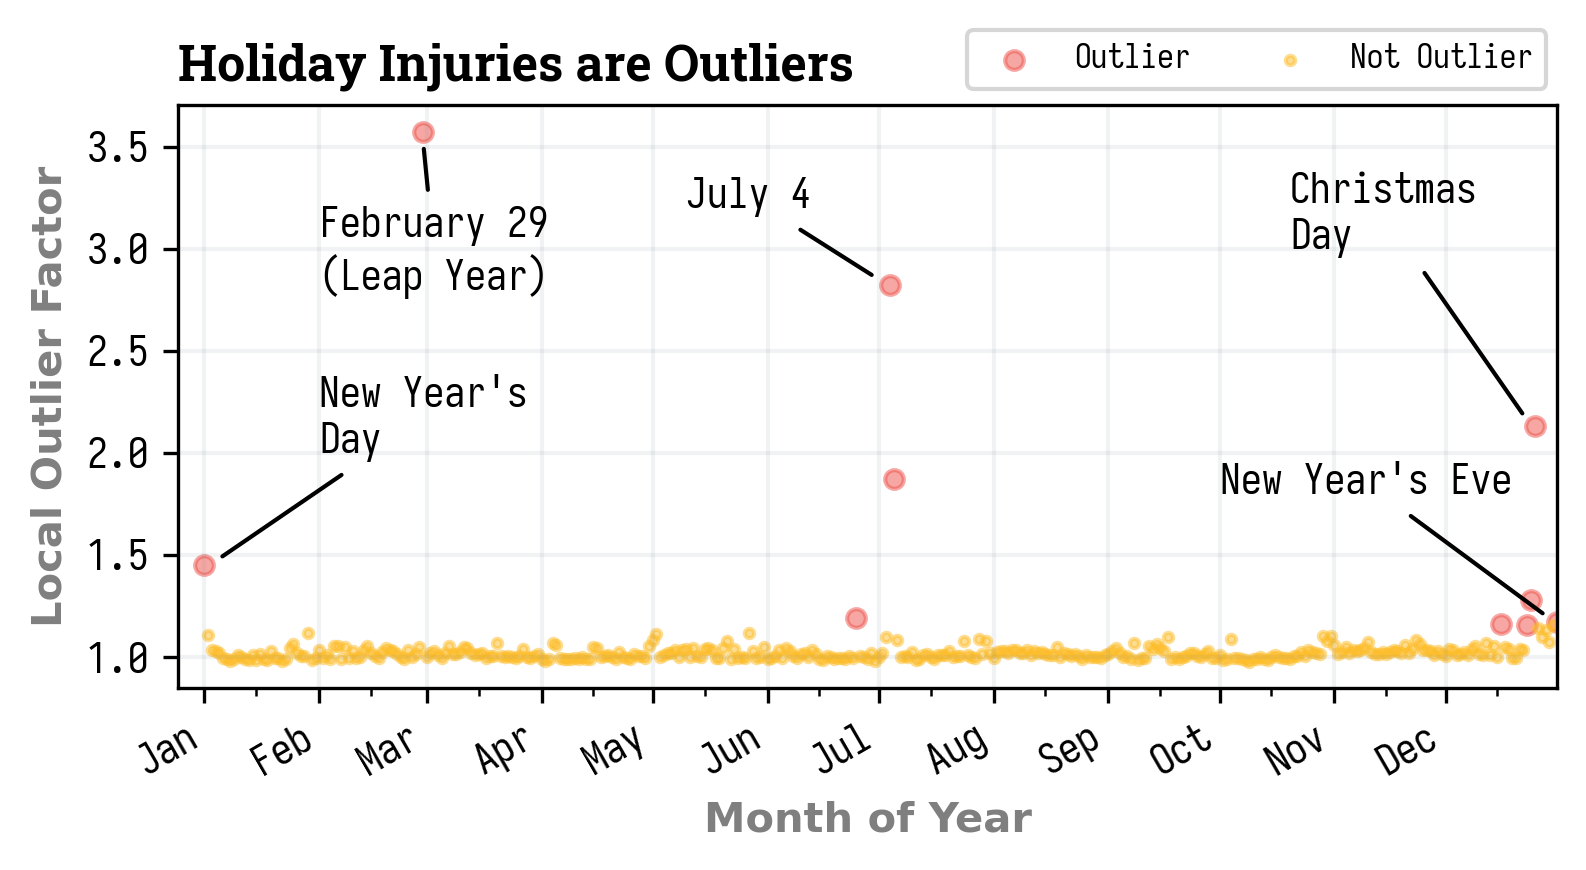

In [525]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

GREY = '#788995'
BLUE = '#0059ff'
GOLD = '#fdbd28'
GREEN = '#28D9AA'
RED = '#EE5149'
METAL_SUN = '#AD8D40'
DARK_ORCHID = '#9A34D1'
MAGENTA = '#8A4859'
OXFORD = '#121C3B'
PINK = '#DB9995'

colormap = np.array([RED, GOLD])
y_plot = y_pred
y_plot[y_pred==-1]=0


fig, ax = plt.subplots(figsize=(5.5,3), dpi=300)
dates = [datetime.date(2020, x, y) for x, y in byday_grouped.index.values]
scatter1 = ax.scatter(np.array(dates)[y_pred == 0], -1*clf.negative_outlier_factor_[y_pred == 0], c=RED, alpha = 0.5, label="Outlier", s=20)
scatter2 = ax.scatter(np.array(dates)[y_pred == 1], -1*clf.negative_outlier_factor_[y_pred == 1], c=GOLD, alpha = 0.5, label = "Not Outlier", s=5)
fmt_month = mdates.MonthLocator()
fmt_day = mdates.DayLocator(15)
ax.xaxis.set_major_locator(fmt_month)
ax.xaxis.set_minor_locator(fmt_day)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Legend
leg = plt.legend(loc="lower left", bbox_to_anchor=(0.56, 1), prop = {"family": "iosevka", "size":8}, ncol=2)

#handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
#legend2 = ax.legend(handles, labels, loc="upper right", title=None)

# grid
ax.grid(b=True, color=GREY, alpha=0.1, linewidth=1)
ax.grid(b=True, axis="y", color=GREY, alpha=0.1, linewidth=1)
plt.xticks(fontfamily="iosevka")
plt.yticks(fontfamily="iosevka")


ax.annotate('July 4', (datetime.date(2020, 7, 1), 2.85),
            (datetime.date(2020, 5, 10), 3.2), fontsize=10, arrowprops={'arrowstyle':'-', 'color':'k'}, fontfamily="iosevka")
ax.annotate('Christmas\nDay', (datetime.date(2020, 12, 23), 2.16),
            (datetime.date(2020, 10, 20), 3), fontsize=10, arrowprops={'arrowstyle':'-', 'color':'k'}, fontfamily="iosevka")
ax.annotate("New Year's Eve", (datetime.date(2020, 12, 29), 1.19),
            (datetime.date(2020, 10, 1), 1.8), fontsize=10, arrowprops={'arrowstyle':'-', 'color':'k'}, fontfamily="iosevka")
ax.annotate("New Year's\nDay", (datetime.date(2020, 1, 4), 1.47),
            (datetime.date(2020, 2, 1), 2), fontsize=10, arrowprops={'arrowstyle':'-', 'color':'k'}, fontfamily="iosevka")
ax.annotate("February 29\n(Leap Year)", (datetime.date(2020, 2, 29), 3.53),
            (datetime.date(2020, 2, 1), 2.8), fontsize=10, arrowprops={'arrowstyle':'-', 'color':'k'}, fontfamily="iosevka")
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.set_xlim([datetime.date(2019, 12, 25), datetime.date(2020, 12, 31)])
ax.set_xlabel("Month of Year", fontfamily="Roboto", color="black", alpha = 0.5, weight="bold")
ax.set_ylabel("Local Outlier Factor", fontfamily="Roboto", color="black", alpha = 0.5, weight="bold")
ax.set_title("Holiday Injuries are Outliers", fontdict = {'fontfamily':"roboto slab", 'weight':'bold'}, loc="left")
fig.autofmt_xdate()
fig.tight_layout()
fix.patch.set_facecolor('white')

plt.show()

/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


([], [])

In [366]:
np.array(dates)[y_pred==0]

array([datetime.date(2020, 1, 1), datetime.date(2020, 2, 29),
       datetime.date(2020, 6, 25), datetime.date(2020, 7, 4),
       datetime.date(2020, 7, 5), datetime.date(2020, 12, 16),
       datetime.date(2020, 12, 23), datetime.date(2020, 12, 24),
       datetime.date(2020, 12, 25), datetime.date(2020, 12, 31)],
      dtype=object)

In [204]:
clf.negative_outlier_factor_

array([-1.44901857, -1.10591421, -1.03296918, -1.0275657 , -1.01853001,
       -0.99474042, -0.99052554, -0.98063202, -0.98969606, -1.00978548,
       -0.99789291, -0.98864296, -0.98649343, -1.0118619 , -0.985651  ,
       -1.01680336, -0.98856383, -0.98655928, -1.02766334, -0.99581323,
       -0.9963176 , -0.98274149, -0.99055312, -1.04218328, -1.06236905,
       -1.02118752, -1.00508625, -1.00693794, -1.11544503, -0.98331931,
       -0.99314181, -1.03260883, -0.99348416, -1.0116968 , -0.99247684,
       -1.05539353, -1.05436391, -0.98916424, -1.04841041, -0.99667224,
       -1.02854906, -0.99429601, -1.00014839, -1.03595946, -1.05477919,
       -1.02055215, -1.00386989, -0.99649248, -1.02356183, -1.04419633,
       -1.03420804, -1.02912901, -1.01247152, -0.99817286, -0.99178829,
       -1.03662371, -1.00117287, -1.01400797, -1.05063052, -3.57284961,
       -0.99804705, -1.01801474, -1.02766137, -1.00972532, -0.99409601,
       -1.02027424, -1.05535821, -1.01679242, -1.01253279, -1.02